# Bias Mitigation Experiments - COMPAS

## Table of Contents

<!-- To return to the table of contents, click on the number at any major section heading.

* [1. Prepare COMPAS data](#1.-Prepare-COMPAS-data)

* [2. Training Baseline Models](#2.-Training-Baseline-Models)
    * [2.1 Logistic Regression](#2.1-Learning-a-Logistic-Regression-(LR)-classifier-on-original-data)
    * [2.2 Random Forest](#2.2-Learning-a-Random-Forest-(RF)-classifier-on-original-data)

* [3. Bias mitigation using pre-processing technique](#3.-Bias-mitigation-using-pre-processing-technique)

   * [3.1 Reweighing](#3.1-Reweighing)
       * [3.1.1 RW on Logistic Regression](#3.1.1.-Learning-a-Logistic-Regression-(LR)-classifier-on-data-transformed-by-reweighing)
       * [3.1.2 RW on Random Forest](#3.1.2.-Learning-a-Random-Forest-(RF)-classifier-on-data-transformed-by-reweighing)
   * [3.2 Disparate impact remover ](#3.2-Disparate-impact-remover)
       * [3.2.1 DIR on Logistic Regression](#3.2.1-Learning-a-Logistic-Regression-(LR)-classifier-on-data-transformed-by-DIR)
       * [3.2.2 DIR on Random Forest](#3.2.2-Learning-a-Random-Forest-(RF)-classifier-on-data-transformed-by-DIR)
  
* [4. Bias mitigation using in-processing technique](#4.-Bias-mitigation-using-in-processing-technique)
    * [4.1 Prejudice Remover (PR)](#4.1-Prejudice-Remover-(PR))
    * [4.2 Adversarial Debiasing](#4.2-Adversarial-Debiasing)

* [5. Bias mitigation using post-processing technique](#5.-Bias-mitigation-using-post-processing-technique)
    * [5.1 Reject option classification (ROC)](#5.1-Reject-option-classification-(RejOpCl))
        * [5.1.1 ROC on Logistic Regression](#5.1.1-Reject-option-classification-on-Logistic-Regression)
        * [5.1.2 ROC on Random Forest](#5.1.2-Reject-option-classification-on-Random-Forest)
    * [5.2 Equalized odds processor (EOPP)](#5.2-Equalized-odds-processor-(EqOddsPr))
        * [5.2.1 EOPP on Logistic Regression](#5.2.1-Equalized-odds-processor-on-Logistic-Regression)
        * [5.2.2 EOPP on Random Forest](#5.2.2-Equalized-odds-processor-on-Random-Forest)

* [6. Summary of results](#6.-Summary-of-Model-Learning-Results)

* [7. Analyze rates of different mitigators](#7.-Analyze-rates-of-different-mitigators)

 -->

In [1]:
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import helperfunctions as helpers
%load_ext autoreload
%autoreload 2
# allow automatic reloading of changes in helperfile

In [3]:
# Standard packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
import seaborn as sns
import random
from tqdm import tqdm
from numpy import mean
from numpy import std
from IPython.display import Markdown, display

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import statistical_parity_difference, average_odds_difference, equal_opportunity_difference, average_odds_error
from aif360.sklearn.metrics import disparate_impact_ratio

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
# from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing import LFR
from aif360.sklearn.preprocessing import ReweighingMeta, LearnedFairRepresentations
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, RejectOptionClassifier


# Set plot font
plt.rcParams.update({'font.family':'serif'})
plt.rcParams.update({'font.serif':'Times New Roman'})

pip install 'aif360[FairAdapt]'
pip install 'aif360[LFR]'


## [1.](#Table-of-Contents) Prepare COMPAS data

In [4]:
# read in data as pandas data frame
df = pd.read_csv("../data/Compas/compas-scores-two-years.csv")
# check columns
pd.set_option('display.max_columns', None) # expand all columns
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:
# select features of interest
df = df[['sex','age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','c_charge_degree', 'two_year_recid']]

# unique values of the protected feature race
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [6]:
# encode protected features 

# make race (=protected attribute) a binary variable
array = ['Caucasian', 'African-American'] # only include samples corresponding to Caucasian or African-American
df = df.loc[df['race'].isin(array)]

def protected_race(row):
    if row['race'] == 'Caucasian': # Caucasian is the privileged group in this case
        value = 1
    else:
        value = 0
    return value

df['race'] = df.apply(protected_race, axis=1)

# make sex a binary variable
def protected_sex(row):
    if row['sex'] == 'Female': # female is the privileged group in this case
        value = 1
    else:
        value = 0
    return value

df['sex'] = df.apply(protected_sex, axis=1)

In [7]:
# one hot encoding of object features
categorical_cols = list(df.select_dtypes(exclude=[np.number]).columns)
df = pd.get_dummies(df, columns = categorical_cols)

# encode binary feature: c_charge 
df = df.drop(['c_charge_degree_F'], axis=1)
# reset index
df = df.reset_index(drop=True)

In [8]:
# flip labels to ensure pos_label = 1, not becoming recidivist
df['two_year_recid'] = (~df['two_year_recid'].astype(bool)).astype(int)

# select descriptive features and target variable
X = df.loc[:, df.columns != 'two_year_recid'] # select all features but target feature
y = df[['race', 'two_year_recid']] # include protected feature in order to AIF360

In [9]:
# set protected attribute as index
X = X.set_index(['race'], append = True, drop = False)
y = y.set_index(['race'], append = True)

# make y data frames to 1d array to pass modeling, but keep index (protected attribute)
y = pd.Series(y['two_year_recid'], index=y.index)

## [2.](#Table-of-Contents) Proposed GridSearch Approach 

The GridSearch Approach includes hyperparameter, threshold, and Bias Mitigation

In [61]:
def store_metrics(y_test, y_pred, pred_prob, thres_dict, threshold):
    """Returns a dictionary with all interested accuracy and fairness metrics.
        Args:
            y_test (array-like): true labels from test set.
            y_pred (array-like): predicted labels for test set.
            thres_dict (dict): dictionary that stores all info.
            threshold (np.float): given threshold used to obtain y_pred.
        Returns:
            dict: `thres_dict`
    """
    
    # evaluate model performance for each split
    thres_dict[threshold]['acc_score'] += [accuracy_score(y_test, y_pred)]
    thres_dict[threshold]['bacc_score'] += [balanced_accuracy_score(y_test, y_pred)]
    thres_dict[threshold]['f1_score'] += [f1_score(y_test, y_pred)]
    thres_dict[threshold]['auc_score'] += [roc_auc_score(y_test, pred_prob)]
    thres_dict[threshold]['spd_score'] += [statistical_parity_difference(y_test, y_pred, prot_attr='race')]
    thres_dict[threshold]['aod_score'] += [average_odds_difference(y_test, y_pred, prot_attr='race')]

    return thres_dict

def get_avg_metrics(thres_dict):
    """Returns the average of all cv splits from the same model setting (hyperparameter and threshold).
    Args:
        thres_dict (dict): the dictionary with all info on each cv split.
    Returns:
        dict: `final_metrics`
    """ 
    import copy
    # calculate the average for each metrics from all splits
    avg_metrics = copy.deepcopy(thres_dict)
    for threshold in avg_metrics.keys(): 
        average_list = {}
        for metric in avg_metrics[threshold].keys():
            average_list['avg_%s'%metric] = mean(avg_metrics[threshold][metric])
        avg_metrics[threshold]['average'] = average_list
    return avg_metrics

def get_output_table(all_metrics, base):
    """Returns the output table from all param_grid.
    Args:
        all_metrics (dict): the final dictionary with info from all param_grid.
        base (str): the name of the base estimator that is shown in the output table.
    """ 

    output_table = pd.DataFrame()
    for model in all_metrics.keys():
        all_metrics[model]['parameters']['hparam'].pop('random_state', None)
        table_cv = pd.DataFrame(all_metrics[model]['metrics']['average'], index=[0])
        table_cv.insert(0, 'model', base)
        table_cv.insert(1, 'param', str(all_metrics[model]['parameters']['hparam']))
        table_cv.insert(2, 'Bias_Mitigation', str(all_metrics[model]['parameters']['Bias_Mitigation']))
        table_cv.insert(3, 'threshold', all_metrics[model]['parameters']['threshold'])
        # table_cv[table_cv.Bias_Mitigation.isin(['AD']),['model','param']] = None
        table_cv[['model','param']] = np.where(table_cv['Bias_Mitigation'].isin(['AD']), '', table_cv[['model','param']])
        output_table = pd.concat([output_table, table_cv]).reset_index(drop=True)
        
    output_table.Bias_Mitigation = output_table.Bias_Mitigation.replace({'no_BM':''})
    return output_table

def style_table(df):
    """Returs the output table with highlight on the best metrics
    Args:
        df (DataFrame): the output table to be styled
    """
    accuracy_metrics = ['avg_'+col for col in ['acc_score', 'bacc_score', 'f1_score', 'auc_score']]
    fairness_metrics = ['avg_'+col for col in ['spd_score', 'aod_score']]


    df = df.style.highlight_max(subset=accuracy_metrics,color='lightgreen')\
                   .apply(lambda s: ['background: yellow' if abs(cell)==min(abs(s)) else '' for cell in s], subset=fairness_metrics)
    
    return df

In [62]:
# i = 0
# param_grid = {'hyperp_grid': {'solver':['lbfgs', 'sag']}, 
#               'threshold': np.linspace(0.3, 0.7, 2),
#               'Bias_Mitigation':[None]}
# thres_arr = param_grid['threshold']
# BM_arr = param_grid['Bias_Mitigation']
# param = list(ParameterGrid(param_grid['hyperp_grid']))[i]
# thres_BM_dict = {}
# # logistic regression classifier with stratified kfold cross validation
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# thres_dict = {threshold: {'acc_score':[], 'bacc_score': [], 'f1_score': [], 'auc_score': [], 'spd_score': [], 'aod_score': []}\
#               for threshold in thres_arr}

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
#     y_train , y_test = y[train_index] , y[test_index]

#     # normalize data features, fit on training set to avoid data leakage
#     scaler = StandardScaler()
#     scaler.fit(X_train[X_train.columns])
#     X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
#     X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

#     model = ReweighingMeta(estimator=LogisticRegression(**param))
#     model.fit(X_train,y_train)
#     for threshold in thres_arr:
#         pred_prob = model.predict_proba(X_test)[:, 1]
#         y_pred = (pred_prob >= threshold).astype('int') # set threshold

#         thres_dict = store_metrics(y_test, y_pred, thres_dict, threshold)
#     avg_metrics = get_avg_metrics(thres_dict)
#     # thres_BM_dict[BM_name] = avg_metrics


# y_pred

In [63]:
# old
# class skf_model():
#     def __init__(self, cv, report, random_state):
#         self.cv = cv
#         self.report = report
#         self.random_state = random_state
        
#     # @methods
#     def get_metrics(self, X, y, base='LR', param = {}, BM_arr=[None], thres_arr=[0.5]):
#         # logistic regression classifier with stratified kfold cross validation
#         skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)
#         thres_dict = {threshold: {'acc_score':[], 'bacc_score': [], 'f1_score': [], 'auc_score': [],
#                                   'spd_score': [], 'aod_score': []}\
#                       for threshold in thres_arr}
#         thres_BM_dict = {}
        
#         for train_index, test_index in skf.split(X, y):
#             X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
#             y_train , y_test = y[train_index] , y[test_index]

#             # normalize data features, fit on training set to avoid data leakage
#             scaler = StandardScaler()
#             scaler.fit(X_train[X_train.columns])
#             X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
#             X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

#             # fit model
#             param.update({'random_state': self.random_state})
#             if base=='LR':
#                 base_estimator=LogisticRegression(**param)
#             elif base=='RF':
#                 base_estimator=RandomForestClassifier(**param)
                
#             for BM in BM_arr:
#                 BM_name = BM
#                 if BM == None:
#                     BM_name = 'no_BM'
#                     model = base_estimator
#                 elif BM == 'RW':
#                     model = ReweighingMeta(estimator=base_estimator)
#                 elif BM == 'AD':
#                     model = AdversarialDebiasing(prot_attr='race', random_state=self.random_state)

#                 model.fit(X_train,y_train)
#                 for threshold in thres_arr:
#                     pred_prob = model.predict_proba(X_test)[:,1]
#                     y_pred = (pred_prob >= threshold).astype('int') # set threshold

#                     thres_dict = store_metrics(y_test, y_pred, pred_prob, thres_dict, threshold)
#                 avg_metrics = get_avg_metrics(thres_dict)
#                 thres_BM_dict[BM_name] = avg_metrics

#         return thres_BM_dict

In [64]:
class skf_model():
    def __init__(self, pos_label, priv_group, cv, random_state):
        self.pos_label = pos_label
        self.priv_group = priv_group
        self.cv = cv
        self.random_state = random_state
        
    # @methods
    def get_metrics(self, X, y, base='LR', param = {}, BM_arr=[None], thres_arr=[0.5]):
        # logistic regression classifier with stratified kfold cross validation
        skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)
        thres_dict = {threshold: {'acc_score':[], 'bacc_score': [], 'f1_score': [], 'auc_score': [],
                                  'spd_score': [], 'aod_score': []}\
                      for threshold in thres_arr}
        thres_BM_dict = {}
        
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
            y_train , y_test = y[train_index] , y[test_index]

            # normalize data features, fit on training set to avoid data leakage
            scaler = StandardScaler()
            scaler.fit(X_train[X_train.columns])
            X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
            X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

            # fit model
            param.update({'random_state': self.random_state})
            if base=='LR':
                base_estimator=LogisticRegression(**param)
            elif base=='RF':
                base_estimator=RandomForestClassifier(**param)
                
            for BM in BM_arr:
                BM_name = BM
                if BM in [None, 'ROC']:
                    model = base_estimator                   
                    if BM == None:
                        BM_name = 'no_BM'
                elif BM == 'RW':
                    model = ReweighingMeta(estimator=base_estimator)
                elif BM == 'AD':
                    model = AdversarialDebiasing(prot_attr='race', random_state=self.random_state)
                
                model.fit(X_train,y_train)
                pred_prob_all = model.predict_proba(X_test)
                pred_prob = pred_prob_all[:,1]

                for threshold in thres_arr:
                    y_pred = (pred_prob >= threshold).astype('int') # set threshold
                    if BM !='ROC':
                        thres_dict = store_metrics(y_test, y_pred, pred_prob, thres_dict, threshold)
                    else: # Post-Processing
                        # fit the primary prediction to post-processing models  
                        post_model = RejectOptionClassifier(prot_attr='race',threshold=threshold)
                        post_model.fit(X_train,y_train,pos_label=self.pos_label,priv_group=self.priv_group)
                        # get final prediction
                        intial_pred = pd.DataFrame(pred_prob_all, index=X_test.index)
                        final_pred_prob = post_model.predict_proba(intial_pred)[:,1]
                        final_y_pred = (final_pred_prob >= threshold).astype('int') # set threshold
                        thres_dict = store_metrics(y_test, final_y_pred, final_pred_prob, thres_dict, threshold)
                avg_metrics = get_avg_metrics(thres_dict)
                thres_BM_dict[BM_name] = avg_metrics

        return thres_BM_dict

In [65]:
class GridsearchCV_LRC():
    def __init__(self, param_grid, pos_label, priv_group, cv=10, random_state=1234):
        self.param_grid = param_grid
        self.pos_label = pos_label
        self.priv_group = priv_group
        self.cv = cv
        self.random_state = random_state
        

    def fit(self, X=X, y=y, random_state=1234):
        """Run fit with all sets of parameters.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples, n_output) \
            or (n_samples,), default=None
            Target relative to X for classification or regression;
            None for unsupervised learning.
        Returns
        -------
        self : object
            Instance of fitted estimator.
        """

        base = 'LR'
        if 'hyperp_grid' in self.param_grid: 
            hyperp_grid = list(ParameterGrid(param_grid['hyperp_grid']))
        else: hyperp_grid = [{'penalty':'l2'}] # default setting    
        if 'Bias_Mitigation' not in self.param_grid: 
            param_grid['Bias_Mitigation'] = [None]        
        if 'threshold' not in self.param_grid: 
            param_grid['threshold'] = [0.5]

        all_metrics = {}
        for i, param in enumerate(tqdm(hyperp_grid)):
            print(param)
            model = skf_model(self.pos_label, self.priv_group, self.cv, self.random_state)
            metrics = model.get_metrics(X=X, y=y, base=base, param=param, 
                                        BM_arr=param_grid['Bias_Mitigation'], thres_arr=param_grid['threshold'])
            # print(metrics)
            for j, BM in enumerate(metrics.keys()):
                for k,thres in enumerate(metrics[BM].keys()):
                    all_param = {'hparam':param, 'Bias_Mitigation':BM, 'threshold':thres}
                    all_metrics['LR_%s%s%s'%(i,j,k)] = {'parameters':all_param, 'metrics':metrics[BM][thres]}
                    
        self.all_metrics = all_metrics
        self.output_table = get_output_table(all_metrics, base=base)

        param_col = ['model','param','Bias_Mitigation','threshold']
        self._best_index = np.argmax(self.output_table.avg_acc_score)
        self._best_param = self.output_table.loc[self._best_index, param_col]

        return self

In [67]:
# param_grid = {'hyperp_grid': {'C':[1, 10],'solver':['liblinear', 'saga'],'penalty':['l1','l2']}, 
#               'threshold': np.linspace(0.3, 0.7, 7),
#               'Bias_Mitigation':[None,'RW','AD']}
param_grid = {'hyperp_grid': {'C':[0.1, 1]},
              'threshold': np.linspace(0.3, 0.7, 2),
              'Bias_Mitigation':[None,'AD']}
clf = GridsearchCV_LRC(param_grid=param_grid, pos_label=0, priv_group=1)
clf.fit(X=X, y=y)

  0%|                                                     | 0/2 [00:00<?, ?it/s]2023-01-09 19:27:13.207810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 19:27:13.207833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-09 19:27:13.348201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'C': 0.1}


2023-01-09 19:27:13.393313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:27:32.344613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:27:32.434483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 19:27:32.434504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-09 19:27:32.561373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:27:32.59

{'C': 1}


2023-01-09 19:30:27.209533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:30:27.255531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:30:46.298219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:30:46.404670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 19:30:46.404698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-09 19:30:46.53

In [68]:
results = clf.output_table
print(clf._best_param)
style_table(results)

model                 
param                 
Bias_Mitigation     AD
threshold          0.3
Name: 6, dtype: object


,model,param,Bias_Mitigation,threshold,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_spd_score,avg_aod_score
0,LR,{'C': 0.1},,0.300000,0.614121,0.590374,0.722823,0.722040,-0.101276,-0.085521
1,LR,{'C': 0.1},,0.700000,0.578691,0.599100,0.428227,0.722040,-0.089080,-0.065156
2,,,AD,0.300000,0.616423,0.592860,0.723923,0.722111,-0.103070,-0.086630
3,,,AD,0.700000,0.578455,0.598848,0.428583,0.722111,-0.086540,-0.062555
4,LR,{'C': 1},,0.300000,0.614377,0.590694,0.722813,0.722087,-0.100719,-0.084782
5,LR,{'C': 1},,0.700000,0.579375,0.599695,0.430293,0.722087,-0.088955,-0.064904
6,,,AD,0.300000,0.616667,0.593165,0.723913,0.722156,-0.102541,-0.085927
7,,,AD,0.700000,0.579106,0.599413,0.430545,0.722156,-0.086421,-0.062315


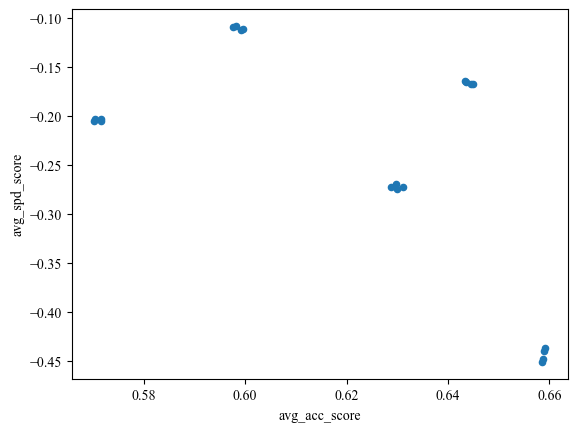

In [17]:
import matplotlib.pyplot as plt
results.plot(x="avg_acc_score", y="avg_spd_score", kind="scatter")
plt.show()

In [22]:
class GridsearchCV_RFC():
    def __init__(self, param_grid, pos_label, priv_group, cv=10, random_state=1234):
        self.param_grid = param_grid
        self.pos_label = pos_label
        self.priv_group = priv_group
        self.cv = cv
        self.random_state = random_state

    def fit(self, X=X, y=y, random_state=1234):
        """Run fit with all sets of parameters.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples, n_output) \
            or (n_samples,), default=None
            Target relative to X for classification or regression;
            None for unsupervised learning.
        Returns
        -------
        self : object
            Instance of fitted estimator.
        """
        
        base = 'RF'
        if 'hyperp_grid' in self.param_grid: 
            hyperp_grid = list(ParameterGrid(param_grid['hyperp_grid']))
        else: hyperp_grid = [{'penalty':'l2'}] # default setting    
        if 'Bias_Mitigation' not in self.param_grid: 
            param_grid['Bias_Mitigation'] = [None]        
        if 'threshold' not in self.param_grid: 
            param_grid['threshold'] = [0.5]

        all_metrics = {}
        for i, param in enumerate(tqdm(hyperp_grid)):
            print(param)
            model = skf_model(self.pos_label, self.priv_group, self.cv, self.random_state)
            metrics = model.get_metrics(X=X, y=y, base=base, param=param, 
                                        BM_arr=param_grid['Bias_Mitigation'], thres_arr=param_grid['threshold'])
            # print(metrics)
            for j, BM in enumerate(metrics.keys()):
                for k,thres in enumerate(metrics[BM].keys()):
                    all_param = {'hparam':param, 'Bias_Mitigation':BM, 'threshold':thres}
                    all_metrics['LR_%s%s%s'%(i,j,k)] = {'parameters':all_param, 'metrics':metrics[BM][thres]}

           
        self.all_metrics = all_metrics
        self.output_table = get_output_table(all_metrics, base=base)

        param_col = ['model','param','Bias_Mitigation','threshold']
        self._best_index = np.argmax(self.output_table.avg_acc_score)
        self._best_param = self.output_table.loc[self._best_index, param_col]

        return self

In [25]:
# param_grid = {'hyperp_grid': {'n_estimators':[10, 100],'criterion':['gini', 'entropy'], 'max_depth':[8, None]}, 
#               'threshold': np.linspace(0.3, 0.7, 7),
#               'Bias_Mitigation':[None,'RW','AD']}
param_grid = {'hyperp_grid': {'n_estimators':[10, 100]},
              'threshold': np.linspace(0.3, 0.7, 11),
              'Bias_Mitigation':[None,'ROC']}
clf_RF = GridsearchCV_RFC(param_grid=param_grid, pos_label=0, priv_group=1)
clf_RF.fit(X=X, y=y)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

{'n_estimators': 10}


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.24s/it]

{'n_estimators': 100}


100%|█████████████████████████████████████████████| 2/2 [00:06<00:00,  3.25s/it]


In [26]:
results_RF = clf_RF.output_table
print(clf_RF._best_param)
style_table(results_RF)

model                                 RF
param              {'n_estimators': 100}
Bias_Mitigation                      ROC
threshold                           0.38
Name: 35, dtype: object


,model,param,Bias_Mitigation,threshold,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_spd_score,avg_aod_score
0,RF,{'n_estimators': 10},,0.300000,0.613179,0.596608,0.699104,0.656073,-0.104741,-0.087797
1,RF,{'n_estimators': 10},,0.340000,0.624305,0.611318,0.695460,0.656229,-0.108492,-0.087708
2,RF,{'n_estimators': 10},,0.380000,0.623534,0.612258,0.688407,0.655672,-0.107741,-0.087249
3,RF,{'n_estimators': 10},,0.420000,0.625674,0.617417,0.678391,0.655535,-0.114529,-0.091680
4,RF,{'n_estimators': 10},,0.460000,0.621481,0.615738,0.663836,0.655946,-0.142552,-0.120664
5,RF,{'n_estimators': 10},,0.500000,0.622507,0.620169,0.649050,0.656537,-0.223290,-0.200999
6,RF,{'n_estimators': 10},,0.540000,0.615490,0.615834,0.628863,0.655713,-0.171556,-0.149751
7,RF,{'n_estimators': 10},,0.580000,0.608472,0.610677,0.611695,0.655582,-0.164615,-0.144242
8,RF,{'n_estimators': 10},,0.620000,0.605648,0.611144,0.589093,0.655808,-0.156760,-0.137392
9,RF,{'n_estimators': 10},,0.660000,0.591613,0.599495,0.557745,0.655637,-0.155223,-0.137774


In [ ]:
import matplotlib.pyplot as plt
results_RF.plot(x="avg_acc_score", y="avg_spd_score", kind="scatter")
plt.show()